In [1]:
import os
import numpy as np
import pandas as pd



# 모델 수 및 클라이언트 수
M = 53  # 모델 수 (src_001~src_053)
J = 53  # 클라이언트 수 (tgt_001~tgt_053)

# 경로 설정 (파일들이 저장된 디렉토리)
dir_path = "./raw/"  # 파일이 업로드된 디렉토리 경로

# probs, labels 초기화
probs = {i: {} for i in range(1, M+1)}  # probs[i][j] -> 확률 값
labels = {j: [] for j in range(1, J+1)}  # labels[j] -> 라벨 값

# CSV 파일 로드 및 전처리
for i in range(1, M+1):  # 모델 번호
    for j in range(1, J+1):  # 클라이언트 번호
        file_path = os.path.join(dir_path, f"src_{str(i).zfill(3)}/probs/tgt_{str(j).zfill(3)}.csv")
        
        # 각 파일이 존재하면 읽기
        if os.path.exists(file_path):
            df = pd.read_csv(file_path)
            
            # 확률(p_A)과 라벨(label_num) 추출
            probs[i][j] = df['p_A'].values  # 모델 i의 클라이언트 j에 대한 p(A) 확률
            labels[j] = df['label_num'].values  # 클라이언트 j에 대한 라벨
            
        else:
            print(f"Warning: File {file_path} not found!")

# 데이터 확인
print(probs[1][1][:5])  # 첫 번째 모델과 첫 번째 클라이언트에 대한 확률 예시
print(labels[1][:5])  # 첫 번째 클라이언트에 대한 라벨 예시

[0.32082132 0.21206881 0.63703084 0.30735803 0.59266663]
[0 0 0 0 1]


In [2]:
print(probs)
print(labels)

{1: {1: array([0.32082132, 0.21206881, 0.63703084, 0.30735803, 0.59266663,
       0.2814056 , 0.76629364, 0.62245935, 0.65135491, 0.7879312 ,
       0.54673815, 0.54673815, 0.51561993, 0.5       , 0.79818678,
       0.74316794, 0.86703575, 0.45326188, 0.71859437, 0.79818678,
       0.40733343, 0.67917871, 0.5774954 , 0.45326188, 0.23370634,
       0.30735803, 0.11920292, 0.71859437, 0.73105854, 0.4378235 ,
       0.20181322, 0.56217653, 0.21206881, 0.46879065, 0.56217653,
       0.59266663, 0.65135491, 0.89330941, 0.256832  , 0.30735803]), 2: array([0.77729988, 0.54673815, 0.83548355, 0.53120941, 0.34864515,
       0.56217653, 0.65135491, 0.46879065, 0.5774954 , 0.66541058,
       0.37754068, 0.53120941, 0.33458945, 0.37754068, 0.73105854,
       0.30735803, 0.2814056 , 0.62245935, 0.51561993, 0.53120941,
       0.4843801 , 0.256832  , 0.42250463, 0.46879065, 0.79818678,
       0.8080672 , 0.63703084, 0.94334757, 0.66541058, 0.256832  ,
       0.51561993, 0.62245935, 0.754915  , 0.8175

In [3]:
from typing import Dict

def nll_i_to_j(p: np.ndarray, q: np.ndarray, smooth_eps: float = 1e-9) -> float:
    """Binary NLL calculation."""
    # 라벨 스무딩 (옵션)
    q_ = (1 - smooth_eps) * q + smooth_eps * (1 - q)
    
    # 확률 클리핑
    p = np.clip(p, smooth_eps, 1 - smooth_eps)
    
    # NLL 계산
    nll = -np.mean(q_ * np.log(p) + (1 - q_) * np.log(1 - p))
    return nll

def compute_T_matrix(probs: Dict[int, Dict[int, np.ndarray]], labels: Dict[int, np.ndarray], smooth_eps: float = 1e-9) -> np.ndarray:
    """Compute the Transferability proxy T."""
    T = np.zeros((M, J))  # 모델 x 클라이언트 크기의 행렬
    
    for i in range(1, M+1):
        for j in range(1, J+1):
            T[i-1, j-1] = nll_i_to_j(probs[i][j], labels[j], smooth_eps)
    
    # 열별(min-max) 정규화
    T = (T - T.min(axis=0)) / (T.max(axis=0) - T.min(axis=0))  # column-wise normalization
    return T

T_matrix = compute_T_matrix(probs, labels)

In [4]:
print(T_matrix)

[[0.01312877 0.07578465 0.026989   ... 0.02170287 0.02021342 0.00998189]
 [0.06719562 0.03735079 0.01657782 ... 0.07894832 0.06693726 0.039493  ]
 [0.06301895 0.06711772 0.00754464 ... 0.06226566 0.05465998 0.04162106]
 ...
 [0.02816211 0.07961476 0.0266187  ... 0.         0.03332706 0.04378748]
 [0.00946096 0.06386644 0.06023751 ... 0.05226959 0.01517259 0.        ]
 [0.         0.0314482  0.02950195 ... 0.03779954 0.0400641  0.01750562]]


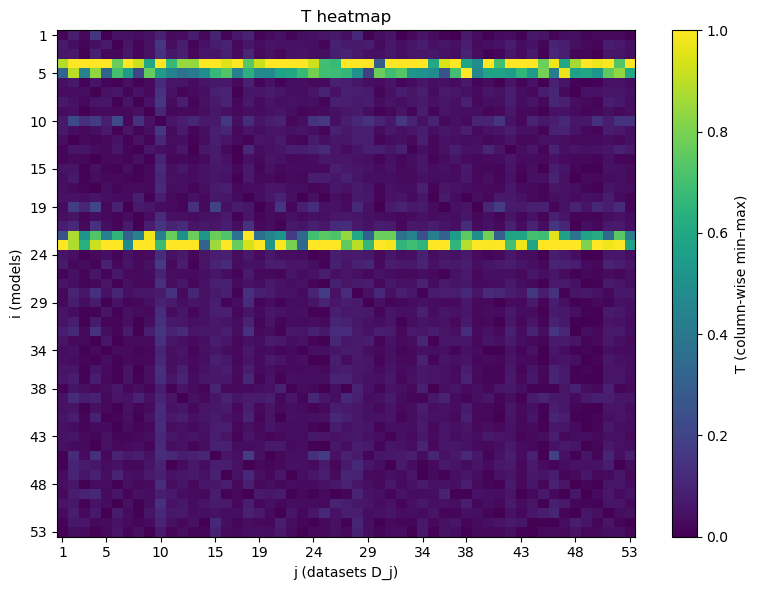

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm

def plot_heatmap_T(
    T_matrix,
    title="T heatmap",
    cmap="RdBu_r",        # 추천 diverging
    center=0.5            # 0.5를 중립(흰색/밝은색)으로
):
    T = np.asarray(T_matrix)
    norm = TwoSlopeNorm(vmin=0.0, vcenter=center, vmax=1.0)

    plt.figure(figsize=(8, 6))
    im = plt.imshow(T, aspect='auto', cmap=cmap, norm=norm)
    plt.title(title)
    plt.xlabel('j (datasets D_j)')
    plt.ylabel('i (models)')
    cbar = plt.colorbar(im)
    cbar.set_label('T (column-wise min–max)', rotation=90)

    # 보기 좋은 1-based 눈금
    ni, nj = T.shape
    plt.xticks(
        np.linspace(0, nj-1, min(nj, 12), dtype=int),
        [str(x) for x in np.linspace(1, nj, min(nj, 12), dtype=int)]
    )
    plt.yticks(
        np.linspace(0, ni-1, min(ni, 12), dtype=int),
        [str(x) for x in np.linspace(1, ni, min(ni, 12), dtype=int)]
    )
    plt.tight_layout()
    plt.show()

# 예시:
# plot_heatmap_T(T_matrix, cmap="RdBu_r")       # 깔끔, 대비 적당
# plot_heatmap_T(T_matrix, cmap="RdYlBu_r")     # 대비 강함(보색+노랑)
# plot_heatmap_T(T_matrix, cmap="coolwarm")     # 부드러운 대비
plot_heatmap_T(T_matrix, cmap="viridis")      # 중립 불필요할 때(순차형)


In [6]:
import numpy as np
from typing import Dict, Tuple

def _bernoulli_js(p: np.ndarray, q: np.ndarray, eps: float = 1e-9) -> float:
    """
    Bernoulli JS divergence 평균. p, q: (n,) 확률 벡터.
    반환: 샘플 평균 JS (스칼라).
    """
    p = np.clip(p, eps, 1 - eps)
    q = np.clip(q, eps, 1 - eps)
    m = 0.5 * (p + q)
    def kl(a, b):
        # return a * np.log(a / b) + (1 - a) * np.log((1 - a) / (1 - b))
        return a * np.log2(a / b) + (1 - a) * np.log2((1 - a) / (1 - b))
    js = 0.5 * (kl(p, m) + kl(q, m))
    return float(js.mean())

def compute_S_matrix(
    probs: Dict[int, Dict[int, np.ndarray]],
    labels: Dict[int, np.ndarray],
    threshold: float = 0.5,
    weight_mode: str = "uniform",   # "uniform" or "size"
    use_js: bool = False,
    alpha: float = 0.5,             # JS 보강할 때 결합 비율: S* = (1-alpha)S + alpha*(1-JS)
    eps_js: float = 1e-9
) -> np.ndarray:
    """
    모델-모델 유사도 S (둘 다 정답 비율의 클라이언트 평균).
    use_js=True이면 S* = (1-alpha) S + alpha (1-JS)로 보강해 반환.

    probs[i][j] -> (n_j,) 확률벡터, labels[j] -> (n_j,) 0/1
    """
    model_ids = sorted(probs.keys())
    client_ids = sorted(labels.keys())
    I, J = len(model_ids), len(client_ids)

    # 클라이언트 가중치
    if weight_mode == "size":
        w = np.array([len(labels[j]) for j in client_ids], dtype=np.float64)
    else:  # "uniform"
        w = np.ones(J, dtype=np.float64)
    w = w / w.sum()

    # 정답 여부 캐시
    correct = {i: {} for i in model_ids}
    for j in client_ids:
        q = labels[j].astype(int)
        for i in model_ids:
            yh = (probs[i][j] > threshold).astype(int)
            correct[i][j] = (yh == q).astype(int)

    # S 계산: 클라이언트별 both_correct 비율의 가중 평균
    S = np.zeros((I, I), dtype=np.float64)
    for ai, i in enumerate(model_ids):
        for bi, v in enumerate(model_ids):
            if bi < ai:
                continue
            s = 0.0
            for t, j in enumerate(client_ids):
                both = correct[i][j] & correct[v][j]  # (n_j,)
                s += w[t] * float(both.mean())       # j별 비율을 평균/가중평균
            S[ai, bi] = S[bi, ai] = s
    np.fill_diagonal(S, 1.0)

    if not use_js:
        return S

    # JS 보강: 클라이언트별 JS 평균 -> 1-JS를 similarity로 사용
    Sjs = np.zeros((I, I), dtype=np.float64)
    for ai, i in enumerate(model_ids):
        for bi, v in enumerate(model_ids):
            if bi < ai:
                continue
            js_mean = 0.0
            for t, j in enumerate(client_ids):
                js_mean += w[t] * _bernoulli_js(probs[i][j], probs[v][j], eps=eps_js)
            sim_js = max(0.0, 1.0 - js_mean)
            Sjs[ai, bi] = Sjs[bi, ai] = sim_js
    np.fill_diagonal(Sjs, 1.0)

    # 결합
    Sstar = (1.0 - alpha) * S + alpha * Sjs
    np.fill_diagonal(Sstar, 1.0)
    return Sstar

In [7]:
# 기존 T_matrix 인자는 제거 (사용 안 함)
S_matrix = compute_S_matrix(
    probs, labels,
    threshold=0.5,
    weight_mode="uniform",     # 지금은 각 j가 40이므로 uniform 추천
    use_js=True,               # JS 보강 사용
    alpha=0.5,                 # 결합 비율
    eps_js=1e-9
)

print(S_matrix)

[[1.         0.61740485 0.65147687 ... 0.71749189 0.70619774 0.70734086]
 [0.61740485 1.         0.63338599 ... 0.64915993 0.66139024 0.67162677]
 [0.65147687 0.63338599 1.         ... 0.66945694 0.6250753  0.6316263 ]
 ...
 [0.71749189 0.64915993 0.66945694 ... 1.         0.69278215 0.70750195]
 [0.70619774 0.66139024 0.6250753  ... 0.69278215 1.         0.75482285]
 [0.70734086 0.67162677 0.6316263  ... 0.70750195 0.75482285 1.        ]]


In [8]:
import numpy as np
from typing import Optional, Tuple
from itertools import combinations

# ---------------------------
# k-medoids (PAM)
# ---------------------------
def _pam_k_medoids(
    D: np.ndarray,
    K: int,
    n_init: int = 16,
    max_iter: int = 200,
    rng: Optional[np.random.Generator] = None
) -> Tuple[np.ndarray, np.ndarray, float]:
    """
    Partitioning Around Medoids with multi-start.
    Returns (medoids_indices, cluster_labels, total_cost).
    """
    n = D.shape[0]
    rng = rng or np.random.default_rng(42)

    best_cost = np.inf
    best_meds = None
    best_labels = None

    for _ in range(n_init):
        meds = rng.choice(n, K, replace=False)
        labels_k = np.argmin(D[:, meds], axis=1)
        cur_cost = float(D[np.arange(n), meds[labels_k]].sum())

        for _ in range(max_iter):
            improved = False
            non_medoids = np.setdiff1d(np.arange(n), meds, assume_unique=True)

            for mi in range(K):
                for h in non_medoids:
                    new_meds = meds.copy()
                    new_meds[mi] = h
                    new_labels = np.argmin(D[:, new_meds], axis=1)
                    new_cost = float(D[np.arange(n), new_meds[new_labels]].sum())
                    if new_cost + 1e-12 < cur_cost:
                        meds = new_meds
                        labels_k = new_labels
                        cur_cost = new_cost
                        improved = True
                        break
                if improved:
                    break

            if not improved:
                break

        if cur_cost < best_cost:
            best_cost = cur_cost
            best_meds = meds
            best_labels = labels_k

    return best_meds, best_labels, best_cost


def reorder_medoids_and_labels(medoids: np.ndarray, labels: np.ndarray):
    """
    medoids를 오름차순으로 정렬하고, 그에 맞춰 labels도 재매핑.
    """
    order = np.argsort(medoids)      # old_idx -> 위치
    inv_perm = np.empty_like(order)  # inv_perm[old_idx] = new_idx
    inv_perm[order] = np.arange(len(order))
    new_medoids = medoids[order]
    new_labels  = inv_perm[labels]
    return new_medoids, new_labels


# ---------------------------
# Silhouette (all / macro / excl singletons)
# ---------------------------
def silhouette_macro_and_excl_from_D(D: np.ndarray, labels: np.ndarray):
    """
    D: (n,n) 거리행렬(대칭, diag=0)
    labels: 0..K-1
    반환: Silhouette 요약 + a(i)/b(i) 평균/벡터
    Keys:
      - silhouette_all:      (1/N) * sum_i s(i)
      - silhouette_macro:    (1/K) * sum_k \bar{s}_k,  \bar{s}_k = cluster k 평균 s(i)
      - silhouette_excl:     size>=2 포인트만 평균
      - sbar_by_cluster:     {k: \bar{s}_k}
      - singleton_ratio_clusters: 싱글톤 클러스터 비율
      - a_mean, b_mean, a_vec, b_vec, s_vec
    """
    n = D.shape[0]
    uniq = np.unique(labels)

    a = np.zeros(n, dtype=float)
    b = np.zeros(n, dtype=float)
    s = np.zeros(n, dtype=float)

    for k in uniq:
        idx_k = np.where(labels == k)[0]
        m = idx_k.size
        if m <= 1:
            if m == 1:
                # 싱글톤: s(i)=0으로 정의
                a[idx_k[0]] = 0.0
                b[idx_k[0]] = 0.0
                s[idx_k[0]] = 0.0
            continue

        # a(i): 같은 군집 평균거리
        a_i = D[np.ix_(idx_k, idx_k)].sum(axis=1) / (m - 1)

        # b(i): 가장 가까운 외부 군집 평균거리
        other_means = []
        for t in uniq:
            if t == k:
                continue
            idx_t = np.where(labels == t)[0]
            if idx_t.size == 0:
                continue
            other_means.append(D[np.ix_(idx_k, idx_t)].mean(axis=1))
        b_i = np.min(np.vstack(other_means), axis=0) if other_means else np.zeros_like(a_i)

        denom = np.maximum(a_i, b_i) + 1e-12
        s[idx_k] = (b_i - a_i) / denom
        a[idx_k] = a_i
        b[idx_k] = b_i

    # (1) pointwise 평균
    silhouette_all = float(np.mean(s)) if n > 0 else 0.0

    # (2) macro by cluster
    sbar_by_cluster = {}
    sbar_list = []
    singleton_clusters = 0
    for k in uniq:
        idx_k = np.where(labels == k)[0]
        if idx_k.size <= 1:
            sbar_by_cluster[int(k)] = 0.0
            sbar_list.append(0.0)
            if idx_k.size == 1:
                singleton_clusters += 1
        else:
            m = float(s[idx_k].mean())
            sbar_by_cluster[int(k)] = m
            sbar_list.append(m)
    silhouette_macro = float(np.mean(sbar_list)) if sbar_list else 0.0

    # (3) excl singletons
    mask_excl = np.zeros(n, dtype=bool)
    for k in uniq:
        idx_k = np.where(labels == k)[0]
        if idx_k.size >= 2:
            mask_excl[idx_k] = True
    silhouette_excl = float(np.mean(s[mask_excl])) if mask_excl.any() else 0.0

    return {
        "silhouette_all": silhouette_all,
        "silhouette_macro": silhouette_macro,
        "silhouette_excl": silhouette_excl,
        "sbar_by_cluster": sbar_by_cluster,
        "singleton_ratio_clusters": (singleton_clusters/len(uniq)) if len(uniq) else 0.0,
        "a_mean": float(np.mean(a)) if n > 0 else 0.0,
        "b_mean": float(np.mean(b)) if n > 0 else 0.0,
        "a_vec": a, "b_vec": b, "s_vec": s,
    }


# ---------------------------
# Intra/Inter (macro/micro), Nearest-Inter, Gini
# ---------------------------
def _gini_of_sizes(sizes):
    if len(sizes) == 0:
        return 0.0
    xs = np.sort(np.array(sizes, dtype=float))
    cum = np.cumsum(xs)
    K = len(xs)
    return float(1.0 - (2.0/(K*cum[-1]))*np.sum(cum) + 1.0/K)

def cluster_metrics_from_S_and_labels(S: np.ndarray, labels: np.ndarray):
    """
    S: (n,n) 유사도(대칭, diag≈1), labels: 0..K-1
    반환: intra_macro/micro, inter_macro/micro, nearest_inter(size-weighted), gini, etc.
    """
    n = S.shape[0]
    uniq = np.unique(labels)
    C = {int(k): np.where(labels == k)[0] for k in uniq}
    sizes = {k: C[k].size for k in C}

    # Intra_k
    intra_k = {}
    pair_sum, pair_cnt = 0.0, 0
    for k in uniq:
        idx = C[int(k)]
        if idx.size >= 2:
            vals = [S[i, v] for (i, v) in combinations(idx.tolist(), 2)]
            intra_k[int(k)] = float(np.mean(vals))
            pair_sum += float(np.sum(vals))
            pair_cnt += len(vals)
        else:
            intra_k[int(k)] = 0.0
    intra_macro = float(np.mean(list(intra_k.values()))) if intra_k else 0.0
    valid_intra = [intra_k[k] for k in intra_k if sizes[k] >= 2]
    intra_macro_excl = float(np.mean(valid_intra)) if valid_intra else 0.0
    intra_micro = (pair_sum / pair_cnt) if pair_cnt > 0 else 0.0

    # Inter_{k,u}
    inter_ku = {}
    cross_sum_total, cross_pairs_total = 0.0, 0
    for a in uniq:
        for b in uniq:
            if b <= a:
                continue
            ia, ib = C[int(a)], C[int(b)]
            if ia.size == 0 or ib.size == 0:
                inter_ku[(int(a), int(b))] = 0.0
                continue
            block = S[np.ix_(ia, ib)]
            inter_ku[(int(a), int(b))] = float(block.mean())
            cross_sum_total += float(block.sum())
            cross_pairs_total += block.size
    inter_macro = float(np.mean(list(inter_ku.values()))) if inter_ku else 0.0
    inter_micro = (cross_sum_total / cross_pairs_total) if cross_pairs_total > 0 else 0.0

    # Nearest-Inter (size-weighted)
    D = 1.0 - S
    nearest_terms, weights = [], []
    for k in uniq:
        k = int(k)
        nk = sizes[k]
        if nk == 0:
            continue
        best_u, best_d = None, np.inf
        for u in uniq:
            u = int(u)
            if u == k or sizes[u] == 0:
                continue
            d_mean = float(D[np.ix_(C[k], C[u])].mean())
            if d_mean < best_d:
                best_d, best_u = d_mean, u
        if best_u is None:
            continue
        s_mean = float(S[np.ix_(C[k], C[best_u])].mean())
        nearest_terms.append(nk * s_mean)
        weights.append(nk)
    nearest_inter = (sum(nearest_terms)/sum(weights)) if sum(weights) > 0 else 0.0

    gini = _gini_of_sizes(list(sizes.values()))
    effectiveK = sum(1 for k in sizes if sizes[k] >= 2)

    return {
        "intra_k": intra_k,
        "intra_macro": intra_macro,
        "intra_macro_excl": intra_macro_excl,
        "intra_micro": intra_micro,
        "inter_macro": inter_macro,
        "inter_micro": inter_micro,
        "nearest_inter": nearest_inter,     # ↑일수록 분리도 나쁨
        "cluster_sizes": sizes,
        "gini": gini,                       # ↑일수록 크기 불균형 심함
        "effectiveK_non_singleton": effectiveK,
        "inter_ku": inter_ku,
    }

# ====== (A) 라벨 기반 보조 함수들 ======
def r_med_from_labels(S: np.ndarray, D: np.ndarray, labels: np.ndarray) -> float:
    # 각 클러스터 medoid(라벨 기준) 구하고, 포인트별 '자기 medoid vs 타군집 medoid 최소거리' 비교
    uniq = np.unique(labels)
    C = {int(k): np.where(labels == k)[0] for k in uniq}
    meds = {}
    for k, idx in C.items():
        if idx.size == 0:
            meds[k] = None
            continue
        if idx.size == 1:
            meds[k] = idx[0]
        else:
            subD = D[np.ix_(idx, idx)]
            mlocal = idx[np.argmin(subD.sum(axis=1))]
            meds[k] = mlocal

    n = S.shape[0]
    violations = 0
    for i in range(n):
        ki = int(labels[i])
        mi = meds[ki]
        if mi is None:
            continue
        di_self = D[i, mi]
        best_other = np.inf
        for ku, mu in meds.items():
            if ku == ki or mu is None:
                continue
            if D[i, mu] < best_other:
                best_other = D[i, mu]
        if np.isfinite(best_other) and di_self > best_other + 1e-12:
            violations += 1
    return violations / float(n)


def M_D_from_labels(S: np.ndarray, D: np.ndarray, labels: np.ndarray) -> float:
    # Distance Margin = size-weighted NI_D - IntraDist_micro
    uniq = np.unique(labels)
    C = {int(k): np.where(labels == k)[0] for k in uniq}
    sizes = {k: C[k].size for k in C}

    # IntraDist_micro
    pair_cnt = sum((sizes[k]*(sizes[k]-1))//2 for k in sizes)
    if pair_cnt > 0:
        intra_sum = 0.0
        for k in sizes:
            idx = C[k]
            m = idx.size
            if m >= 2:
                triu = np.triu_indices(m, 1)
                intra_sum += float(S[np.ix_(idx, idx)][triu].sum())
        intra_micro = intra_sum / pair_cnt
    else:
        intra_micro = 0.0
    intraDist_micro = 1.0 - intra_micro

    # size-weighted NI_D
    Dmat = 1.0 - S
    num_sum = 0.0
    w_sum   = 0.0
    for k in sizes:
        idxk = C[k]
        if idxk.size == 0:
            continue
        best = np.inf
        for u in sizes:
            if u == k or sizes[u] == 0:
                continue
            d_mean = float(Dmat[np.ix_(idxk, C[u])].mean())
            if d_mean < best:
                best = d_mean
        if np.isfinite(best):
            num_sum += sizes[k] * best
            w_sum   += sizes[k]
    NI_D_size_weighted = (num_sum / w_sum) if w_sum > 0 else 0.0

    return NI_D_size_weighted - intraDist_micro


def MD_min_from_labels(S: np.ndarray, D: np.ndarray, labels: np.ndarray) -> float:
    # Worst-Cluster Margin = min_k [ NI_D(k) - Dbar_intra(Ck) ]
    uniq = np.unique(labels)
    C = {int(k): np.where(labels == k)[0] for k in uniq}
    sizes = {k: C[k].size for k in C}
    Dmat = 1.0 - S

    worst = np.inf
    for k in sizes:
        idxk = C[k]
        m = idxk.size
        if m <= 1:
            continue
        # Dbar_intra(Ck)
        triu = np.triu_indices(m, 1)
        Dintra = float(Dmat[np.ix_(idxk, idxk)][triu].mean())
        # NI_D(k)
        best = np.inf
        for u in sizes:
            if u == k or sizes[u] == 0:
                continue
            d_mean = float(Dmat[np.ix_(idxk, C[u])].mean())
            if d_mean < best:
                best = d_mean
        if np.isfinite(best):
            margin_k = best - Dintra
            if margin_k < worst:
                worst = margin_k
    return 0.0 if not np.isfinite(worst) else float(worst)


# ====== (B) 널-보정(Z-score) 유틸 ======
def null_standardize_metric_from_labels(S: np.ndarray,
                                        D: np.ndarray,
                                        labels: np.ndarray,
                                        metric_fn,
                                        R: int = 500,
                                        rng: Optional[np.random.Generator] = None):
    """
    labels의 클러스터 크기 분포(n1..nK)는 유지하고, 라벨만 R회 셔플 → metric의 null 분포를 만들고
    Z = (obs - mean) / std 반환
    """
    rng = rng or np.random.default_rng(123)
    n = labels.shape[0]
    uniq, counts = np.unique(labels, return_counts=True)
    obs = float(metric_fn(S, D, labels))

    null_vals = []
    base = np.arange(n)
    for _ in range(R):
        rng.shuffle(base)
        # 사이즈 분포 유지된 새 라벨 만들기
        new_labels = np.empty(n, dtype=int)
        offset = 0
        for k, c in zip(uniq, counts):
            new_labels[base[offset:offset+c]] = k
            offset += c
        null_vals.append(float(metric_fn(S, D, new_labels)))

    null_vals = np.array(null_vals, dtype=float)
    mu = null_vals.mean()
    sd = null_vals.std(ddof=1) + 1e-12
    z  = (obs - mu) / sd
    return {"obs": obs, "null_mean": mu, "null_std": sd, "z": z}


# ====== (C) PAM 라벨 결과를 한 번에 요약 ======
def summarize_pam_result(name, S, D, medoids, labels, cost, R=500):
    meds_sorted, lbls_sorted = reorder_medoids_and_labels(medoids, labels)

    print(f"\n### [PAM] {name}")
    print("Best medoids (0-based, sorted):", meds_sorted.tolist())

    sil = silhouette_macro_and_excl_from_D(D, lbls_sorted)
    print(f"Silhouette (all)   : {sil['silhouette_all']:.6f}")
    print(f"Silhouette (macro) : {sil['silhouette_macro']:.6f}")
    print(f"Silhouette (excl1) : {sil['silhouette_excl']:.6f}")
    print(f"  singleton ratio  : {sil['singleton_ratio_clusters']:.3f}")

    var = cluster_metrics_from_S_and_labels(S, lbls_sorted)
    print(f"Intra_micro        : {var['intra_micro']:.6f}")
    print(f"Inter_micro        : {var['inter_micro']:.6f}")
    print(f"Nearest-Inter (S)  : {var['nearest_inter']:.6f}   # ↑일수록 분리도 나쁨")
    print(f"Sizes              : {var['cluster_sizes']}")
    print(f"Gini(size)         : {var['gini']:.4f}")
    print(f"PAM Cost           : {float(cost):.6f}")

    extra = extra_metrics_from_S_and_labels(S, D, lbls_sorted)
    print("[Proposed metrics - raw]")
    print(f"  r_neg                    : {extra['r_neg']:.3f}   (↑ 나쁨)")
    print(f"  Burden                   : {extra['burden']:.4f} (↑ 나쁨)")
    print(f"  M_D                      : {extra['M_D']:.6f}    (↑ 좋음)")
    print(f"  NI_D (size-weighted)     : {extra['NI_D_size_weighted']:.6f} (↑ 좋음)")
    print(f"  NI_D_min (worst cluster) : {extra['NI_D_min']:.6f} (↑ 좋음)")
    print(f"  IntraDist_micro          : {extra['IntraDist_micro']:.6f}")

    rmed_raw = r_med_from_labels(S, D, lbls_sorted)
    rmed_ns  = null_standardize_metric_from_labels(S, D, lbls_sorted, r_med_from_labels, R=R)
    print("[Medoid Violation]")
    print(f"  r_med (raw)              : {rmed_raw:.4f}  (↓ 좋음)")
    print(f"  r_med Z (null-std, +good): {-rmed_ns['z']:.3f}  # Z는 ↑가 좋음이라 부호 반전")

    md_raw = M_D_from_labels(S, D, lbls_sorted)
    md_ns  = null_standardize_metric_from_labels(S, D, lbls_sorted, M_D_from_labels, R=R)
    print("[Distance Margin]")
    print(f"  M_D (raw)                : {md_raw:.6f}  (↑ 좋음)")
    print(f"  M_D Z (null-std)         : {md_ns['z']:.3f}  (↑ 좋음)")

    mdmin_raw = MD_min_from_labels(S, D, lbls_sorted)
    mdmin_ns  = null_standardize_metric_from_labels(S, D, lbls_sorted, MD_min_from_labels, R=R)
    print("[Worst-Cluster Margin]")
    print(f"  M_Dmin (raw)             : {mdmin_raw:.6f}  (↑ 좋음)")
    print(f"  M_Dmin Z (null-std)      : {mdmin_ns['z']:.3f}  (↑ 좋음)")




def _nearest_inter_dist_terms_from_labels(S: np.ndarray, labels: np.ndarray):
    """
    각 클러스터 k에 대해 '가장 가까운 외부 군집'까지의 평균거리( Dbar(Ck,Cu) )를 반환.
    - 반환:
        per_cluster_minD: dict{k -> min_u!=k Dbar(Ck,Cu)}
        size_weighted_NI_D:   sum_k n_k * minD_k / sum_k n_k     (크기 가중 평균)
        min_over_clusters:    min_k minD_k                       (가장 위험한 군집의 최근접거리)
    """
    D = 1.0 - S
    uniq = np.unique(labels)
    C = {int(k): np.where(labels == k)[0] for k in uniq}
    sizes = {k: C[k].size for k in C}

    per_cluster_minD = {}
    num_sum = 0.0
    w_sum   = 0.0
    min_over_clusters = np.inf

    for k in uniq:
        k = int(k)
        idxk = C[k]
        if idxk.size == 0:
            per_cluster_minD[k] = np.nan
            continue
        best = np.inf
        for u in uniq:
            u = int(u)
            if u == k or sizes[u] == 0:
                continue
            d_mean = float(D[np.ix_(idxk, C[u])].mean())
            if d_mean < best:
                best = d_mean
        if np.isfinite(best):
            per_cluster_minD[k] = best
            # 크기 가중 최근접-Inter(거리)
            num_sum += sizes[k] * best
            w_sum   += sizes[k]
            if best < min_over_clusters:
                min_over_clusters = best
        else:
            per_cluster_minD[k] = np.nan

    size_weighted_NI_D = (num_sum / w_sum) if w_sum > 0 else 0.0
    if not np.isfinite(min_over_clusters):
        min_over_clusters = 0.0
    return per_cluster_minD, size_weighted_NI_D, float(min_over_clusters)


def extra_metrics_from_S_and_labels(S: np.ndarray, D: np.ndarray, labels: np.ndarray):
    """
    위 4개 지표를 한 번에 계산.
    필요한 중간값은 기존 함수들 출력과 일관되게 재사용/재계산.
    반환 dict:
      r_neg, burden, M_D, NI_D_size_weighted, NI_D_min, IntraDist_micro
    """
    # 1) 실루엣 s(i) : 이미 있는 silhouette 함수에서 s_vec을 얻는게 가장 좋음.
    # 만약 silhouette_macro_and_excl_from_D 가 s_vec을 반환하지 않으면 여기서 직접 계산:
    n = D.shape[0]
    uniq = np.unique(labels)
    s = np.zeros(n, dtype=float)

    for k in uniq:
        idxk = np.where(labels == k)[0]
        if idxk.size <= 1:
            if idxk.size == 1:
                s[idxk[0]] = 0.0
            continue
        # a(i): 같은 군집 평균거리
        a_i = D[np.ix_(idxk, idxk)].sum(axis=1) / (idxk.size - 1)
        # b(i): 가장 가까운 외부군집 평균거리
        other_means = []
        for u in uniq:
            if u == k: 
                continue
            idxu = np.where(labels == u)[0]
            if idxu.size == 0:
                continue
            other_means.append(D[np.ix_(idxk, idxu)].mean(axis=1))
        b_i = np.min(np.vstack(other_means), axis=0) if other_means else np.zeros_like(a_i)
        denom = np.maximum(a_i, b_i) + 1e-12
        s[idxk] = (b_i - a_i) / denom

    # 2) r_neg, burden
    r_neg  = float(np.mean(s < 0))
    burden = float(np.maximum(0.0, -s).mean())

    # 3) Intra micro (유사도) -> 거리 스케일로 변환
    #    labels 버전 intra_micro는 기존 cluster_metrics_from_S_and_labels에서 이미 계산함.
    #    여기서는 독립적으로 계산:
    C = {int(k): np.where(labels == k)[0] for k in uniq}
    sizes = {k: C[k].size for k in C}
    pair_cnt = sum((sizes[k]*(sizes[k]-1))//2 for k in sizes)
    if pair_cnt > 0:
        intra_sum = 0.0
        for k in sizes:
            idx = C[k]
            m = idx.size
            if m >= 2:
                triu = np.triu_indices(m, 1)
                intra_sum += float(S[np.ix_(idx, idx)][triu].sum())
        intra_micro = intra_sum / pair_cnt
    else:
        intra_micro = 0.0
    intraDist_micro = 1.0 - intra_micro

    # 4) 최근접-Inter 거리 (크기 가중 평균) & 최솟값(최악 군집)
    _, NI_D_size_weighted, NI_D_min = _nearest_inter_dist_terms_from_labels(S, labels)

    # 5) Distance Margin
    M_D = NI_D_size_weighted - intraDist_micro

    return {
        "r_neg": r_neg,
        "burden": burden,
        "M_D": M_D,
        "NI_D_size_weighted": NI_D_size_weighted,
        "NI_D_min": NI_D_min,
        "IntraDist_micro": intraDist_micro,
    }








In [9]:
S = S_matrix
D = 1.0 - S
np.fill_diagonal(D, 0.0)

for K in [3,5,7,9]:
    meds, lbls, pam_cost = _pam_k_medoids(D, K=K, n_init=24, max_iter=1000)
    summarize_pam_result(f"K={K}", S, D, meds, lbls, pam_cost, R=500)


### [PAM] K=3
Best medoids (0-based, sorted): [15, 29, 52]
Silhouette (all)   : 0.071652
Silhouette (macro) : 0.088535
Silhouette (excl1) : 0.071652
  singleton ratio  : 0.000
Intra_micro        : 0.679486
Inter_micro        : 0.643520
Nearest-Inter (S)  : 0.653405   # ↑일수록 분리도 나쁨
Sizes              : {0: 24, 1: 8, 2: 21}
Gini(size)         : 0.2013
PAM Cost           : 14.561611
[Proposed metrics - raw]
  r_neg                    : 0.151   (↑ 나쁨)
  Burden                   : 0.0057 (↑ 나쁨)
  M_D                      : 0.026081    (↑ 좋음)
  NI_D (size-weighted)     : 0.346595 (↑ 좋음)
  NI_D_min (worst cluster) : 0.341163 (↑ 좋음)
  IntraDist_micro          : 0.320514
[Medoid Violation]
  r_med (raw)              : 0.0000  (↓ 좋음)
  r_med Z (null-std, +good): 8.182  # Z는 ↑가 좋음이라 부호 반전
[Distance Margin]
  M_D (raw)                : 0.026081  (↑ 좋음)
  M_D Z (null-std)         : 5.348  (↑ 좋음)
[Worst-Cluster Margin]
  M_Dmin (raw)             : 0.012026  (↑ 좋음)
  M_Dmin Z (null-std)      : 3.609

In [10]:
import numpy as np
from itertools import combinations

# --- 기존: dict -> assignment (그대로 사용) ---
def _dict_clusters_to_assignment(clusters_dict, n=53, one_based=True):
    A = -np.ones(n, dtype=int)
    for k, members in clusters_dict.items():
        for idx in members:
            i = idx - 1 if one_based else idx
            A[i] = k
    if np.any(A < 0):
        missing = np.where(A < 0)[0]
        raise ValueError(f"할당 누락 인덱스(0-based): {missing.tolist()}")
    return A

# --- 기존: 주어진 클러스터에 대해 Medoid & Cost (그대로 사용) ---
def compute_medoids_and_cost(S_star: np.ndarray, clusters_dict: dict, one_based=True, fixed_medoids=None):
    S = np.asarray(S_star, dtype=float)
    n = S.shape[0]
    assert S.shape[0] == S.shape[1], "S* must be square"
    np.fill_diagonal(S, 1.0)
    D = 1.0 - S
    np.fill_diagonal(D, 0.0)

    C = {k: np.array([m-1 if one_based else m for m in members], dtype=int)
         for k, members in clusters_dict.items()}
    ks = sorted(C.keys())

    medoids_0 = {}
    for k in ks:
        members = C[k]
        if members.size == 0:
            medoids_0[k] = None
            continue
        if fixed_medoids is not None and k in fixed_medoids:
            m_idx = fixed_medoids[k]
            m0 = (m_idx - 1) if one_based else m_idx
            medoids_0[k] = m0
        else:
            if members.size == 1:
                medoids_0[k] = members[0]
            else:
                intra_dists = D[np.ix_(members, members)]
                totals = intra_dists.sum(axis=1)
                medoids_0[k] = members[np.argmin(totals)]

    cost_per_cluster = {}
    total_cost = 0.0
    for k in ks:
        members = C[k]
        if members.size == 0:
            cost_per_cluster[k] = 0.0
            continue
        m0 = medoids_0[k]
        dists = D[members, m0]
        c = float(dists.sum())
        cost_per_cluster[k] = c
        total_cost += c

    medoids_1 = {k: (None if medoids_0[k] is None else medoids_0[k] + 1) for k in ks}
    return medoids_1, float(total_cost), cost_per_cluster

# ---------------------------
# Silhouette (all / macro / excl) — dict 클러스터 입력용
# ---------------------------
def silhouette_from_dict_D(D: np.ndarray, clusters_dict: dict, one_based=True):
    """
    반환 키를 PAM 버전과 동일하게:
      silhouette_all, silhouette_macro, silhouette_excl,
      sbar_by_cluster, singleton_ratio_clusters,
      a_mean, b_mean, a_vec, b_vec, s_vec
    """
    n = D.shape[0]
    ks = sorted(clusters_dict.keys())
    # 0/1-based 멤버 인덱스
    C = {k: np.array([m-1 if one_based else m for m in clusters_dict[k]], dtype=int) for k in ks}

    a = np.zeros(n, dtype=float)
    b = np.zeros(n, dtype=float)
    s = np.zeros(n, dtype=float)

    for k in ks:
        idx_k = C[k]
        m = idx_k.size
        if m <= 1:
            if m == 1:
                a[idx_k[0]] = 0.0
                b[idx_k[0]] = 0.0
                s[idx_k[0]] = 0.0
            continue
        # a(i)
        a_i = D[np.ix_(idx_k, idx_k)].sum(axis=1) / (m - 1)
        # b(i)
        other_means = []
        for u in ks:
            if u == k or C[u].size == 0:
                continue
            other_means.append(D[np.ix_(idx_k, C[u])].mean(axis=1))
        b_i = np.min(np.vstack(other_means), axis=0) if other_means else np.zeros_like(a_i)
        denom = np.maximum(a_i, b_i) + 1e-12
        s[idx_k] = (b_i - a_i) / denom
        a[idx_k] = a_i
        b[idx_k] = b_i

    # (1) 포인트 평균
    silhouette_all = float(np.mean(s)) if n > 0 else 0.0

    # (2) 매크로(클러스터 평균의 평균)
    sbar_by_cluster, sbar_list, singleton_clusters = {}, [], 0
    for k in ks:
        idx_k = C[k]
        if idx_k.size <= 1:
            sbar_by_cluster[k] = 0.0
            sbar_list.append(0.0)
            if idx_k.size == 1:
                singleton_clusters += 1
        else:
            val = float(s[idx_k].mean())
            sbar_by_cluster[k] = val
            sbar_list.append(val)
    silhouette_macro = float(np.mean(sbar_list)) if sbar_list else 0.0

    # (3) 싱글톤 제외(포인트 단위)
    mask_excl = np.zeros(n, dtype=bool)
    for k in ks:
        if C[k].size >= 2:
            mask_excl[C[k]] = True
    silhouette_excl = float(np.mean(s[mask_excl])) if mask_excl.any() else 0.0

    return {
        "silhouette_all": silhouette_all,
        "silhouette_macro": silhouette_macro,
        "silhouette_excl": silhouette_excl,
        "sbar_by_cluster": sbar_by_cluster,
        "singleton_ratio_clusters": (singleton_clusters/len(ks)) if len(ks) else 0.0,
        "a_mean": float(np.mean(a)) if n > 0 else 0.0,
        "b_mean": float(np.mean(b)) if n > 0 else 0.0,
        "a_vec": a, "b_vec": b, "s_vec": s,
    }

# ---------------------------
# Intra/Inter (macro/micro), Nearest-Inter, Gini — dict 입력용
# ---------------------------
def intra_inter_from_dict_S(S_star: np.ndarray, clusters_dict: dict, one_based=True):
    """
    반환 키를 PAM 버전과 맞춤:
      intra_macro, intra_macro_excl, intra_micro,
      inter_macro, inter_micro, nearest_inter,
      cluster_sizes, gini, effectiveK_non_singleton, inter_ku, intra_k
    """
    S = np.asarray(S_star, dtype=float)
    n = S.shape[0]
    np.fill_diagonal(S, 1.0)
    D = 1.0 - S
    np.fill_diagonal(D, 0.0)

    ks = sorted(clusters_dict.keys())
    C = {k: np.array([m-1 if one_based else m for m in clusters_dict[k]], dtype=int) for k in ks}
    sizes = {k: C[k].size for k in ks}

    # Intra_k
    intra_k = {}
    sum_pairs, cnt_pairs = 0.0, 0
    for k in ks:
        idx = C[k]
        m = idx.size
        if m >= 2:
            block = S[np.ix_(idx, idx)]
            triu = block[np.triu_indices(m, 1)]
            val = float(triu.mean()) if triu.size > 0 else 0.0
            intra_k[k] = val
            sum_pairs += float(triu.sum())
            cnt_pairs += triu.size
        else:
            intra_k[k] = 0.0
    intra_macro = float(np.mean(list(intra_k.values()))) if intra_k else 0.0
    valid_intra = [intra_k[k] for k in ks if sizes[k] >= 2]
    intra_macro_excl = float(np.mean(valid_intra)) if valid_intra else 0.0
    intra_micro = (sum_pairs / cnt_pairs) if cnt_pairs > 0 else 0.0

    # Inter
    inter_ku = {}
    inter_list, cross_sum, cross_cnt = [], 0.0, 0
    for i, k in enumerate(ks):
        for u in ks[i+1:]:
            ck, cu = C[k], C[u]
            if ck.size == 0 or cu.size == 0:
                inter_ku[(k, u)] = 0.0
                inter_list.append(0.0)
                continue
            block = S[np.ix_(ck, cu)]
            val = float(block.mean())
            inter_ku[(k, u)] = val
            inter_list.append(val)
            cross_sum += float(block.sum())
            cross_cnt += block.size
    inter_macro = float(np.mean(inter_list)) if inter_list else 0.0
    inter_micro = (cross_sum / cross_cnt) if cross_cnt > 0 else 0.0

    # Nearest-Inter (size-weighted)
    nearest_terms, weights = [], []
    for k in ks:
        ck = C[k]
        nk = ck.size
        if nk == 0:
            continue
        best_d, best_u = np.inf, None
        for u in ks:
            if u == k or C[u].size == 0:
                continue
            d_mean = float(D[np.ix_(ck, C[u])].mean())
            if d_mean < best_d:
                best_d, best_u = d_mean, u
        if best_u is None:
            continue
        s_mean = float(S[np.ix_(ck, C[best_u])].mean())
        nearest_terms.append(nk * s_mean)
        weights.append(nk)
    nearest_inter = (sum(nearest_terms) / sum(weights)) if sum(weights) > 0 else 0.0

    # Gini (표준 이산형 근사식)
    sizes_arr = np.array(list(sizes.values()), dtype=float)
    if sizes_arr.sum() > 0:
        xs = np.sort(sizes_arr)
        cum = np.cumsum(xs)
        K = len(xs)
        gini = float(1.0 - (2.0/(K*cum[-1]))*np.sum(cum) + 1.0/K)
    else:
        gini = 0.0
    effectiveK = int(np.sum(sizes_arr >= 2))

    return {
        "intra_k": intra_k,
        "intra_macro": intra_macro,
        "intra_macro_excl": intra_macro_excl,
        "intra_micro": intra_micro,
        "inter_macro": inter_macro,
        "inter_micro": inter_micro,
        "nearest_inter": nearest_inter,
        "cluster_sizes": sizes,
        "gini": gini,
        "effectiveK_non_singleton": effectiveK,
        "inter_ku": inter_ku,
    }

# ---------------------------
# 통일 출력 포맷 (PAM 버전과 동일 순서/용어)
# ---------------------------
def evaluate_and_print_given_clusters(S_star, D, clusters_dict, name="clusters", one_based=True, floatfmt=".6f"):
    sil = silhouette_from_dict_D(D, clusters_dict, one_based=one_based)
    var = intra_inter_from_dict_S(S_star, clusters_dict, one_based=one_based)
    medoids, cost, _ = compute_medoids_and_cost(S_star, clusters_dict, one_based=one_based)

    K = len(clusters_dict)
    print(f"\n=== {name} (K={K}) ===")
    # Silhouette
    print(f"Silhouette (all points avg):       {sil['silhouette_all']:{floatfmt}}")
    print(f"Silhouette (macro by cluster):     {sil['silhouette_macro']:{floatfmt}}")
    print(f"  mean a(i): {sil['a_mean']:{floatfmt}}, mean b(i): {sil['b_mean']:{floatfmt}}")
    print(f"  s̄_k by cluster: {sil['sbar_by_cluster']}")
    print(f"  singleton ratio (clusters): {sil['singleton_ratio_clusters']:.3f}")
    print(f"Silhouette (excl singleton clusters):      {sil['silhouette_excl']:{floatfmt}}")

    # Intra / Inter / Nearest-Inter / Gini
    print(f"Intra macro (incl singleton clusters):   {var['intra_macro']:{floatfmt}}")
    print(f"Intra macro excl singleton clusters:       {var['intra_macro_excl']:{floatfmt}}")
    print(f"Intra micro (pair-weighted):       {var['intra_micro']:{floatfmt}}")
    print(f"Inter macro:                        {var['inter_macro']:{floatfmt}}")
    print(f"Inter micro (pair-weighted):        {var['inter_micro']:{floatfmt}}")
    print(f"Nearest-Inter (size-weighted):      {var['nearest_inter']:{floatfmt}}  <-- 값↑ ⇒ 분리도 나쁨/경계 혼선")
    print(f"Cluster sizes: {var['cluster_sizes']}")
    print(f"Gini(size): {var['gini']:.4f} | effective K(>=2): {var['effectiveK_non_singleton']}")

    # Medoid & Cost (주어진 클러스터 기준)
    print(f"Medoids (1-based): {medoids}")
    print(f"Cost: {cost:{floatfmt}}")


    extra = extra_metrics_from_S_and_clusters(S_star, clusters_dict, one_based=one_based)
    print(f"[Proposed metrics]")
    print(f"  Negative-Silhouette Rate r_neg:  {extra['r_neg']:.3f}   (↑ 나쁨)")
    print(f"  Neg-Silhouette Burden B:         {extra['burden']:.4f} (↑ 나쁨)")
    print(f"  Distance Margin M_D:             {extra['M_D']:.6f}     (↓ 나쁨)")
    print(f"  NI_D (size-weighted):            {extra['NI_D_size_weighted']:.6f} (↑ 좋음)")
    print(f"  NI_D_min (worst cluster):        {extra['NI_D_min']:.6f} (↑ 좋음)")


def compute_silhouette_intra_inter(S_star: np.ndarray, clusters_dict: dict, one_based: bool=True):
    S = np.asarray(S_star, dtype=float)
    np.fill_diagonal(S, 1.0)
    D = 1.0 - S
    np.fill_diagonal(D, 0.0)

    sil = silhouette_from_dict_D(D, clusters_dict, one_based=one_based)
    # 최소한 extra_metrics가 쓰는 키만 반환
    return {
        "silhouette_mean": sil["silhouette_all"],
        "a_vec": sil["a_vec"],
        "b_vec": sil["b_vec"],
        "s_vec": sil["s_vec"],
    }



def extra_metrics_from_S_and_clusters(S: np.ndarray, clusters_dict: dict, one_based=True):
    """
    dict형 클러스터가 주어졌을 때 4개 지표 계산.
    (compute_silhouette_intra_inter를 써서 s_vec/assignment를 재활용)
    """
    S = np.asarray(S, dtype=float)
    n = S.shape[0]
    D = 1.0 - S
    np.fill_diagonal(D, 0.0)

    # s_vec 얻기
    res_sil = compute_silhouette_intra_inter(S, clusters_dict, one_based=one_based)
    s = res_sil["s_vec"]  # 이미 0/싱글톤 처리된 벡터

    r_neg  = float(np.mean(s < 0))
    burden = float(np.maximum(0.0, -s).mean())

    # 사이즈, 인덱스
    ks = sorted(clusters_dict.keys())
    C = {k: np.array([m-1 if one_based else m for m in clusters_dict[k]], dtype=int) for k in ks}
    sizes = {k: C[k].size for k in ks}

    # Intra micro (유사도) -> 거리 스케일
    pair_cnt = sum((sizes[k]*(sizes[k]-1))//2 for k in ks)
    if pair_cnt > 0:
        intra_sum = 0.0
        for k in ks:
            idx = C[k]
            m = idx.size
            if m >= 2:
                triu = np.triu_indices(m, 1)
                intra_sum += float(S[np.ix_(idx, idx)][triu].sum())
        intra_micro = intra_sum / pair_cnt
    else:
        intra_micro = 0.0
    intraDist_micro = 1.0 - intra_micro

    # 최근접-Inter 거리 (크기 가중 평균) & 최솟값
    num_sum = 0.0
    w_sum   = 0.0
    worst_min = np.inf
    for k in ks:
        idxk = C[k]
        if idxk.size == 0:
            continue
        best = np.inf
        for u in ks:
            if u == k or C[u].size == 0:
                continue
            d_mean = float(D[np.ix_(idxk, C[u])].mean())
            if d_mean < best:
                best = d_mean
        if np.isfinite(best):
            num_sum += sizes[k]*best
            w_sum   += sizes[k]
            if best < worst_min:
                worst_min = best
    NI_D_size_weighted = (num_sum / w_sum) if w_sum > 0 else 0.0
    NI_D_min = worst_min if np.isfinite(worst_min) else 0.0

    M_D = NI_D_size_weighted - intraDist_micro

    return {
        "r_neg": r_neg,
        "burden": burden,
        "M_D": M_D,
        "NI_D_size_weighted": NI_D_size_weighted,
        "NI_D_min": NI_D_min,
        "IntraDist_micro": intraDist_micro,
    }



def add_null_block_for_dict(name, S, D, clusters_dict, one_based=True, R=500):
    """dict 클러스터에 대해 raw와 Z(null-standardized) 둘 다 출력"""
    labels = _dict_clusters_to_assignment(clusters_dict, n=S.shape[0], one_based=one_based)

    # raw 값 직접 계산
    rmed_raw  = r_med_from_labels(S, D, labels)
    md_raw    = M_D_from_labels(S, D, labels)
    mdmin_raw = MD_min_from_labels(S, D, labels)

    # null 표준화 (같은 (n1..nK) 분포 유지)
    rmed_ns  = null_standardize_metric_from_labels(S, D, labels, r_med_from_labels,  R=R)
    md_ns    = null_standardize_metric_from_labels(S, D, labels, M_D_from_labels,    R=R)
    mdmin_ns = null_standardize_metric_from_labels(S, D, labels, MD_min_from_labels, R=R)

    # 방향 통일: r_med는 ↓가 좋음 → Z에 부호반전해서 ↑가 좋음으로 보고
    rmed_z_good = -rmed_ns['z']

    print(f"[Null-standardized add-on] {name}")
    print(f"[Medoid Violation]")
    print(f"  r_med (raw)              : {rmed_raw:.4f}  (↓ 좋음)")
    print(f"  r_med Z (null-std, +good): {rmed_z_good:.3f}  (↑ 좋음)")
    print(f"[Distance Margin]")
    print(f"  M_D (raw)                : {md_raw:.6f}  (↑ 좋음)")
    print(f"  M_D Z (null-std)         : {md_ns['z']:.3f}  (↑ 좋음)")
    print(f"[Worst-Cluster Margin]")
    print(f"  M_Dmin (raw)             : {mdmin_raw:.6f}  (↑ 좋음)")
    print(f"  M_Dmin Z (null-std)      : {mdmin_ns['z']:.3f}  (↑ 좋음)")



## Plain (FedBiscuit)

In [11]:
c3_p = {
    0: [1,2,7,8,9,10,11,12,14,15,16,17,18,19,21,23,24,26,28,30,32,34,35,36,38,39,41,42,43,44,45,46,48,49,50,51,52,53],
    1: [4,5,6,13,20,25,27,29,31,33,37,40,47],
    2: [3,22],
}

c5_p = {  # 키가 비연속이어도 OK
    0: [8, 9, 10, 11, 12, 14, 15, 17, 23, 26, 27, 32, 34, 35, 38, 41, 45, 49, 53],
    1: [1, 5, 6, 7, 13, 16, 18, 19, 20, 21, 24, 25, 28, 29, 30, 33, 37, 40, 42, 43, 44, 46, 47, 50, 51, 52],
    2: [2, 36, 39, 48],
    4: [3, 4, 22, 31],
}

c7_p = {
    0: [8, 9, 10, 11, 14, 15, 16, 17, 18, 19, 23, 26, 27, 32, 34, 35, 38, 41, 44, 45, 52, 53],
    1: [4, 6, 13, 25, 31, 33],
    2: [3, 5],
    3: [7, 46],
    4: [1, 22, 28, 30, 36, 37, 43, 47, 48, 50, 51],
    5: [21, 24, 29, 39],
    6: [2, 12, 20, 40, 42, 49],
}

c9_p = {
    0: [1, 8, 9, 10, 11, 12, 14, 15, 16, 17, 18, 19, 23, 26, 27, 30, 32, 34, 35, 38, 41, 42, 45, 52, 53],
    1: [5, 20, 25, 29, 33, 37, 40, 50],
    2: [3, 31],
    3: [2, 6, 21, 28, 43, 51],
    4: [7, 22, 36, 48],
    5: [4],
    6: [24],
    7: [13, 46, 47, 49],
    8: [39, 44],
}

c10_p = {
    0: [2, 10, 11, 15, 35, 38, 45],
    1: [5, 6, 7, 23, 36, 40, 49, 51],
    2: [21],
    3: [4, 9, 12, 13, 14, 25, 29, 32, 34, 42, 46],
    4: [1, 24, 30, 33, 37, 50],
    5: [3, 17, 26, 48, 53],
    6: [8, 16, 18, 19, 20, 27, 28, 39, 41, 43, 44],
    7: [52],
    8: [22, 31],
    9: [47],
}


evaluate_and_print_given_clusters(S_matrix, D, c3_p,  name="c3_p",  one_based=True)
add_null_block_for_dict("c3_p", S_matrix, D, c3_p, one_based=True, R=500)
evaluate_and_print_given_clusters(S_matrix, D, c5_p,  name="c5_p",  one_based=True)
add_null_block_for_dict("c5_p", S_matrix, D, c5_p, one_based=True, R=500)
evaluate_and_print_given_clusters(S_matrix, D, c7_p,  name="c7_p",  one_based=True)
add_null_block_for_dict("c7_p", S_matrix, D, c7_p, one_based=True, R=500)
evaluate_and_print_given_clusters(S_matrix, D, c9_p,  name="c9_p",  one_based=True)
add_null_block_for_dict("c9_p", S_matrix, D, c9_p, one_based=True, R=500)
# evaluate_and_print_given_clusters(S_matrix, D, c10_p, name="c10_p", one_based=True)
# add_null_block_for_dict("c10_p", S_matrix, D, c10_p, one_based=True, R=500)



=== c3_p (K=3) ===
Silhouette (all points avg):       0.023876
Silhouette (macro by cluster):     -0.049768
  mean a(i): 0.343683, mean b(i): 0.351051
  s̄_k by cluster: {0: 0.06318032210917846, 1: -0.0645880024160444, 2: -0.14789645453436367}
  singleton ratio (clusters): 0.000
Silhouette (excl singleton clusters):      0.023876
Intra macro (incl singleton clusters):   0.614083
Intra macro excl singleton clusters:       0.614083
Intra micro (pair-weighted):       0.667694
Inter macro:                        0.619414
Inter micro (pair-weighted):        0.642820
Nearest-Inter (size-weighted):      0.648660  <-- 값↑ ⇒ 분리도 나쁨/경계 혼선
Cluster sizes: {0: 38, 1: 13, 2: 2}
Gini(size): 0.4528 | effective K(>=2): 3
Medoids (1-based): {0: 53, 1: 20, 2: 3}
Cost: 15.509559
[Proposed metrics]
  Negative-Silhouette Rate r_neg:  0.340   (↑ 나쁨)
  Neg-Silhouette Burden B:         0.0223 (↑ 나쁨)
  Distance Margin M_D:             0.019033     (↓ 나쁨)
  NI_D (size-weighted):            0.351340 (↑ 좋음)
  NI_D

In [12]:
### Latest version ###


c3_p = {
  "0": [1, 6, 9, 10, 11, 13, 14, 15, 18, 19, 21, 26, 27, 29, 30, 32, 34, 35, 38, 41, 43, 44, 45, 47, 49, 50, 51, 52, 53],
  "1": [4, 5, 7, 8, 16, 17, 23, 28, 40, 42, 46, 48],
  "2": [2, 3, 12, 20, 22, 24, 25, 31, 33, 36, 37, 39],
}

c5_p = {
  "0": [1, 9, 10, 11, 12, 13, 15, 16, 17, 18, 19, 21, 26, 27, 29, 32, 34, 35, 38, 44, 45, 52, 53],
  "1": [4, 5, 6, 7, 23, 28, 40, 42, 46, 49, 50],
  "2": [2, 22, 31, 33, 36, 37, 39, 43, 47],
  "3": [3, 14, 20, 24, 25, 30, 41, 51],
  "4": [8, 48]
}

c7_p = {
  "0": [8, 9, 10, 11, 12, 13, 16, 17, 18, 19, 21, 26, 27, 30, 32, 35, 38, 42, 45, 47, 52, 53],
  "1": [4, 5, 23, 36, 40, 44, 48, 51],
  "2": [3, 24, 25, 31],
  "3": [22, 34, 46],
  "4": [6],
  "5": [14, 29, 37, 49],
  "6": [1, 2, 7, 15, 20, 28, 33, 39, 41, 43, 50],
}

c9_p = {
  "0": [1, 8, 9, 10, 11, 12, 13, 19, 21, 26, 27, 32, 35, 38, 42, 45, 47, 52],
  "1": [5, 23, 28, 36, 40, 48, 49, 51],
  "2": [31],
  "3": [3, 37],
  "4": [7, 22, 34, 50],
  "5": [2, 6, 14, 16, 17, 24, 29, 30, 44, 46, 53],
  "6": [15, 20, 39, 43],
  "7": [18],
  "8": [4, 25, 33, 41]
}

c10_p = {
  "0": [6, 8, 9, 10, 11, 14, 15, 18, 30, 34, 35, 38, 40, 42, 52],
  "1": [5, 7, 51],
  "2": [29, 31, 36, 49],
  "3": [45],
  "4": [4, 23, 24],
  "5": [16, 17, 26, 32, 46, 48, 50],
  "6": [12, 13, 19, 20, 21, 27, 28, 39, 43],
  "7": [],
  "8": [3, 25, 33, 37, 41, 44, 47, 53],
  "9": [1, 2, 22]
}


evaluate_and_print_given_clusters(S_matrix, D, c3_p,  name="c3_p",  one_based=True)
add_null_block_for_dict("c3_p", S_matrix, D, c3_p, one_based=True, R=500)
evaluate_and_print_given_clusters(S_matrix, D, c5_p,  name="c5_p",  one_based=True)
add_null_block_for_dict("c5_p", S_matrix, D, c5_p, one_based=True, R=500)
evaluate_and_print_given_clusters(S_matrix, D, c7_p,  name="c7_p",  one_based=True)
add_null_block_for_dict("c7_p", S_matrix, D, c7_p, one_based=True, R=500)
evaluate_and_print_given_clusters(S_matrix, D, c9_p,  name="c9_p",  one_based=True)
add_null_block_for_dict("c9_p", S_matrix, D, c9_p, one_based=True, R=500)
# evaluate_and_print_given_clusters(S_matrix, D, c10_p, name="c10_p", one_based=True)
# add_null_block_for_dict("c10_p", S_matrix, D, c10_p, one_based=True, R=500)



=== c3_p (K=3) ===
Silhouette (all points avg):       0.005251
Silhouette (macro by cluster):     -0.017785
  mean a(i): 0.342212, mean b(i): 0.343577
  s̄_k by cluster: {'0': 0.054031351536893375, '1': -0.06608931654348908, '2': -0.041295720116243155}
  singleton ratio (clusters): 0.000
Silhouette (excl singleton clusters):      0.005251
Intra macro (incl singleton clusters):   0.648916
Intra macro excl singleton clusters:       0.648916
Intra micro (pair-weighted):       0.666396
Inter macro:                        0.647985
Inter micro (pair-weighted):        0.650876
Nearest-Inter (size-weighted):      0.656052  <-- 값↑ ⇒ 분리도 나쁨/경계 혼선
Cluster sizes: {'0': 29, '1': 12, '2': 12}
Gini(size): 0.2138 | effective K(>=2): 3
Medoids (1-based): {'0': 53, '1': 17, '2': 20}
Cost: 15.634992
[Proposed metrics]
  Negative-Silhouette Rate r_neg:  0.491   (↑ 나쁨)
  Neg-Silhouette Burden B:         0.0247 (↑ 나쁨)
  Distance Margin M_D:             0.010344     (↓ 나쁨)
  NI_D (size-weighted):           

## Balance (FedBiscuit)

In [13]:
# ===== 새 클러스터 세트 정의 (질문 그대로; 1-based 인덱스) =====
c3_b = {
    0: [1,7,8,9,12,14,17,18,19,21,23,26,27,30,32,34,35,37,42,44,49,50,52,53],
    1: [2,6,10,13,15,16,20,24,28,36,38,39,41,43,45,46,47,48],
    2: [3,4,5,11,22,25,29,31,33,40,51],
}

c5_b = {
    0: [2,11,12,14,15,38,39,46],
    1: [4,13,32,40],
    2: [1,6,7,9,10,18,19,20,21,24,25,28,29,30,36,37,41,42,43,47,48,50,51],
    3: [3,5,22,31,33],
    4: [8,16,17,23,26,27,34,35,44,45,49,52,53],
}

c7_b = {
    0: [2,15,24],
    1: [4,5,22,33,40],
    2: [3,31],
    3: [1,9,11,12,13,14,17,23,25,29,30,32,34,42,46,47,51],
    4: [8,26,37,49,50,52,53],
    5: [6,21,28,35,45,48],
    6: [7,10,16,18,19,20,27,36,38,39,41,43,44],
}

c9_b = {
    0: [2,6,18,35,36,45,51],
    1: [5,40,49,53],
    2: [1,10,15,41],
    4: [3,26,46,48,52],
    5: [20,28,30,32,42,43,47,50],
    6: [7,8,9,11,13,14,16,17,19,21,23,24,25,27,34,37,38,39,44],
    7: [4,12,29],
    8: [22,31,33],
}

c10_b = {
    0: [22],
    1: [4],
    2: [3,5,33],
    3: [43],
    5: [6,9,15,18,19,21,25,26,27,29,35,44,45,51,52],
    6: [7,8,11,12,14,16,17,23,30,32,34,38,40,41,42,46,49],
    7: [13,24,31,37,47],
    8: [20,28,36,48,50,53],
    9: [1,2,10,39],
}

# ===== 실행 (요약 출력) =====
# ===== 3) 실행 =====
evaluate_and_print_given_clusters(S_matrix, D, c3_b,  name="c3_b",  one_based=True)
add_null_block_for_dict("c3_b", S_matrix, D, c3_b, one_based=True, R=500)
evaluate_and_print_given_clusters(S_matrix, D, c5_b,  name="c5_b",  one_based=True)
add_null_block_for_dict("c5_b", S_matrix, D, c5_b, one_based=True, R=500)
evaluate_and_print_given_clusters(S_matrix, D, c7_b,  name="c7_b",  one_based=True)
add_null_block_for_dict("c7_b", S_matrix, D, c7_b, one_based=True, R=500)
evaluate_and_print_given_clusters(S_matrix, D, c9_b,  name="c9_b",  one_based=True)
add_null_block_for_dict("c9_b", S_matrix, D, c9_b, one_based=True, R=500)
# evaluate_and_print_given_clusters(S_matrix, c10_b, name="c10_b", one_based=True)
# add_null_block_for_dict("c10_b", S_matrix, D, c10_b, one_based=True, R=500)


=== c3_b (K=3) ===
Silhouette (all points avg):       -0.016263
Silhouette (macro by cluster):     -0.030344
  mean a(i): 0.341815, mean b(i): 0.334919
  s̄_k by cluster: {0: -0.0008421530182765186, 1: 0.02148272012788012, 2: -0.11167375154952976}
  singleton ratio (clusters): 0.000
Silhouette (excl singleton clusters):      -0.016263
Intra macro (incl singleton clusters):   0.649336
Intra macro excl singleton clusters:       0.649336
Intra micro (pair-weighted):       0.664572
Inter macro:                        0.647840
Inter micro (pair-weighted):        0.652801
Nearest-Inter (size-weighted):      0.664151  <-- 값↑ ⇒ 분리도 나쁨/경계 혼선
Cluster sizes: {0: 24, 1: 18, 2: 11}
Gini(size): 0.1635 | effective K(>=2): 3
Medoids (1-based): {0: 53, 1: 16, 2: 51}
Cost: 15.452946
[Proposed metrics]
  Negative-Silhouette Rate r_neg:  0.453   (↑ 나쁨)
  Neg-Silhouette Burden B:         0.0343 (↑ 나쁨)
  Distance Margin M_D:             0.000422     (↓ 나쁨)
  NI_D (size-weighted):            0.335849 (↑ 좋음)

In [14]:
### Latest version ###
c3_b = {
    0: [1, 9, 10, 11, 12, 13, 15, 17, 19, 22, 26, 27, 29, 31, 32, 35, 38, 45],
    1: [3, 5, 6, 8, 16, 18, 20, 21, 25, 28, 34, 41, 44, 46, 48, 50, 52],
    2: [2, 4, 7, 14, 23, 24, 30, 33, 36, 37, 39, 40, 42, 43, 47, 49, 51, 53],
}

c5_b = {
    0: [6, 10, 11, 12, 13, 15, 16, 19, 21, 29, 31, 32, 44, 45, 47, 50, 52],
    1: [5, 14, 17, 23, 34, 36, 42, 49, 51, 53],
    2: [4, 7, 24, 28, 30, 33, 37, 39, 40, 43, 46],
    3: [1, 2, 3, 8, 9, 18, 20, 25, 41, 48],
    4: [10, 11, 12, 13, 19, 22, 26, 27, 35, 38, 45],
}

c7_b = {
    0: [13, 15, 18, 21, 35, 38, 39, 52],
    1: [4, 5, 8, 28, 32, 36, 40, 48],
    2: [2, 3, 7, 24, 33, 37, 47, 53],
    3: [6, 10, 20, 25, 41, 43, 45],
    4: [1, 17, 22, 30, 34, 44, 50],
    5: [14, 16, 23, 26, 42, 46, 49],
    6: [9, 11, 12, 19, 27, 29, 31, 51],
}

c9_b = {
    0: [3, 14, 25, 33, 41, 42],
    1: [9, 13, 21, 31, 38, 51],
    2: [23, 29, 34, 36, 47, 52],
    3: [2, 19, 35, 39, 43, 45],
    4: [11, 22, 26, 32, 46, 50],
    5: [1, 4, 7, 24, 28, 30],
    6: [6, 8, 10, 18, 27],
    7: [12, 15, 16, 20, 40, 44],
    8: [5, 17, 37, 48, 49, 53],
}

c10_b = {
    0: [8, 13, 16, 30, 40, 46],
    1: [20, 28, 36, 48, 49, 53],
    2: [6, 21, 23, 45, 51],
    3: [1, 5, 29, 37, 44],
    4: [9, 14, 32, 34, 50],
    5: [3, 4, 22, 31, 33],
    6: [2, 7, 10, 18, 41],
    7: [12, 24, 25, 42, 47],
    8: [15, 17, 19, 27, 35],
    9: [11, 26, 38, 39, 43, 52],
}

# ===== 실행 (요약 출력) =====
# ===== 3) 실행 =====
evaluate_and_print_given_clusters(S_matrix, D, c3_b,  name="c3_b",  one_based=True)
add_null_block_for_dict("c3_b", S_matrix, D, c3_b, one_based=True, R=500)
evaluate_and_print_given_clusters(S_matrix, D, c5_b,  name="c5_b",  one_based=True)
add_null_block_for_dict("c5_b", S_matrix, D, c5_b, one_based=True, R=500)
evaluate_and_print_given_clusters(S_matrix, D, c7_b,  name="c7_b",  one_based=True)
add_null_block_for_dict("c7_b", S_matrix, D, c7_b, one_based=True, R=500)
evaluate_and_print_given_clusters(S_matrix, D, c9_b,  name="c9_b",  one_based=True)
add_null_block_for_dict("c9_b", S_matrix, D, c9_b, one_based=True, R=500)
# evaluate_and_print_given_clusters(S_matrix, c10_b, name="c10_b", one_based=True)
# add_null_block_for_dict("c10_b", S_matrix, D, c10_b, one_based=True, R=500)


=== c3_b (K=3) ===
Silhouette (all points avg):       -0.013861
Silhouette (macro by cluster):     -0.013927
  mean a(i): 0.342862, mean b(i): 0.338150
  s̄_k by cluster: {0: -0.004286004729661219, 1: -0.017421761551303646, 2: -0.0200728450670893}
  singleton ratio (clusters): 0.000
Silhouette (excl singleton clusters):      -0.013861
Intra macro (incl singleton clusters):   0.657092
Intra macro excl singleton clusters:       0.657092
Intra micro (pair-weighted):       0.657186
Inter macro:                        0.656788
Inter micro (pair-weighted):        0.656817
Nearest-Inter (size-weighted):      0.658585  <-- 값↑ ⇒ 분리도 나쁨/경계 혼선
Cluster sizes: {0: 18, 1: 17, 2: 18}
Gini(size): 0.0126 | effective K(>=2): 3
Medoids (1-based): {0: 9, 1: 20, 2: 53}
Cost: 15.546964
[Proposed metrics]
  Negative-Silhouette Rate r_neg:  0.679   (↑ 나쁨)
  Neg-Silhouette Burden B:         0.0203 (↑ 나쁨)
  Distance Margin M_D:             -0.001400     (↓ 나쁨)
  NI_D (size-weighted):            0.341415 (↑ 좋음)